# Customer Persona (v3)

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
all_customers_file_url = "../data/all_customers.csv"
all_customers_df = pd.read_csv(all_customers_file_url)

# print shape of the data
print(f"online_retail_df shape: {all_customers_df.shape}")
all_customers_df.head(3)

online_retail_df shape: (22316, 21)


,customerId,gender,region,age,Lead Source,main source of income,water source,Motivation to buy,Primary decision maker,Farm acreage,...,NPS Date,Practical/emotional goals,social_media,accounts,household_members,income_level,Discounts,Cluster,Category,Kilimo Boost (Survey)
0,21975,Male,Coast,31–35 years,,farming/ agriculture activities,NaN,Increase of agriculture production for self co...,Husband,2 or less,...,,,NaN,1 Account,3,"1 - 20,000",Promotional Discount,3,Older Rainfed / Seasonal,NaN
1,53039,Female,Western,36–40 years,,commerce/trade activities,NaN,Increase of agriculture production for self co...,Wife,2 or less,...,,,NaN,1 Account,3,"20,001 - 100,000",,2,Business Customer,NaN
2,40815,NaN,Coast,NaN,,NaN,NaN,NaN,NaN,NaN,...,,,NaN,1 Account,0,0,,1,Youth Primary Customers,NaN


In [4]:
def clean_column_names(df):
    """
    Convert column titles to lowercase, replace spaces with underscores,
    replace forward slashes with underscores, and remove multiple spaces.
    
    Parameters:
    df (pandas.DataFrame): Input DataFrame
    
    Returns:
    pandas.DataFrame: DataFrame with cleaned column names
    """
    # Create a copy to avoid modifying the original DataFrame
    result_df = df.copy()
    
    def clean_single_column_name(col_name):
        """
        Clean a single column name by:
        1. Removing multiple spaces (replace with single space)
        2. Converting to lowercase
        3. Replacing spaces with underscores
        4. Replacing slashes with underscores
        """
        # Remove multiple spaces by replacing with single space first
        col_name = ' '.join(col_name.split())
        # Then apply the other transformations
        col_name = col_name.lower().replace(' ', '_').replace('/', '_')
        return col_name
    
    # Clean column names
    result_df.columns = [clean_single_column_name(col) for col in result_df.columns]
    
    return result_df
all_customers_with_cleaned_columns_df = clean_column_names(all_customers_df)
all_customers_with_cleaned_columns_df.head(3)

,customerid,gender,region,age,lead_source,main_source_of_income,water_source,motivation_to_buy,primary_decision_maker,farm_acreage,...,nps_date,practical_emotional_goals,social_media,accounts,household_members,income_level,discounts,cluster,category,kilimo_boost_(survey)
0,21975,Male,Coast,31–35 years,,farming/ agriculture activities,NaN,Increase of agriculture production for self co...,Husband,2 or less,...,,,NaN,1 Account,3,"1 - 20,000",Promotional Discount,3,Older Rainfed / Seasonal,NaN
1,53039,Female,Western,36–40 years,,commerce/trade activities,NaN,Increase of agriculture production for self co...,Wife,2 or less,...,,,NaN,1 Account,3,"20,001 - 100,000",,2,Business Customer,NaN
2,40815,NaN,Coast,NaN,,NaN,NaN,NaN,NaN,NaN,...,,,NaN,1 Account,0,0,,1,Youth Primary Customers,NaN


In [5]:
def check_data_types(df):
    """
    Prints the data types of all columns in the DataFrame.
    """
    for col in df.columns:
        print(f"{col}: {df[col].dtype}")

# usage
check_data_types(all_customers_with_cleaned_columns_df)

customerid: int64
gender: object
region: object
age: object
lead_source: object
main_source_of_income: object
water_source: object
motivation_to_buy: object
primary_decision_maker: object
farm_acreage: object
crops_livestock: object
nps_date: object
practical_emotional_goals: object
social_media: object
accounts: object
household_members: object
income_level: object
discounts: object
cluster: int64
category: object
kilimo_boost_(survey): object


In [6]:
# Specify the column(s) and their desired data types
dtype_dict = {
    'customerid': str
}
def convert_data_types(df, dtype_dict):
    """
    Converts specified columns to the desired data types.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    dtype_dict (dict): A dictionary where keys are column names and values are target data types.
    
    Returns:
    pd.DataFrame: A DataFrame with updated data types.
    """
    # Create a copy to avoid modifying the original DataFrame
    result_df = df.copy()
    
    for column, dtype in dtype_dict.items():
        if column in result_df.columns:
            result_df[column] = result_df[column].astype(dtype)
        else:
            print(f"Warning: Column '{column}' not found in DataFrame.")
    
    return result_df
all_customers_with_corrected_types_df = convert_data_types(all_customers_with_cleaned_columns_df, dtype_dict)
check_data_types(all_customers_with_corrected_types_df)

customerid: object
gender: object
region: object
age: object
lead_source: object
main_source_of_income: object
water_source: object
motivation_to_buy: object
primary_decision_maker: object
farm_acreage: object
crops_livestock: object
nps_date: object
practical_emotional_goals: object
social_media: object
accounts: object
household_members: object
income_level: object
discounts: object
cluster: int64
category: object
kilimo_boost_(survey): object


In [7]:
# descriptive statistics function
def descriptive_statistic(df):
    # Specifying datetime_is_numeric=True adopts the future behavior of Treating datetime data as categorical rather than numeric
    return df.describe(include='all')

descriptive_statistic(all_customers_with_corrected_types_df)

,customerid,gender,region,age,lead_source,main_source_of_income,water_source,motivation_to_buy,primary_decision_maker,farm_acreage,...,nps_date,practical_emotional_goals,social_media,accounts,household_members,income_level,discounts,cluster,category,kilimo_boost_(survey)
count,22316,20375,22278,19770,22316,19969,19717,19999,18591,19902,...,22316,22316,1859,22316,22316,22316,22316,22316.000000,22316,508
unique,22316,2,9,8,9,8,5,6,7,3,...,174,9,5,2,10,6,5,NaN,5,508
top,21975,Male,North Rift,Over 50 years,Walk-ins,farming/ agriculture activities,Well,Increase of agriculture production for sale,Husband,2 or less,...,,,Facebook,1 Account,3,"1 - 20,000",,NaN,Older Irrigated / Non-Seasonal,10090627A
freq,1,13106,7069,6039,6715,5914,14759,17142,9865,15362,...,19711,19711,1146,19899,6291,9366,17523,NaN,7055,1
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.856157,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.531597,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,NaN


## Step : Check `null` Values

In [8]:
def check_null_values(df):
    """
    Function to check for null values in each column of the DataFrame.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame to check for null values.
    
    Returns:
    None
    """
    # Coerce 'nan' strings and other non-standard NaNs to np.nan
    df = df.replace('nan', np.nan)
    
    # Check for empty DataFrame to avoid division by zero
    total_rows = len(df) 
    if total_rows == 0:
        print("The DataFrame is empty.")
        return pd.DataFrame(columns=['Feature', 'Count of Null Values', 'Percentage of Null Values'])
    # Calculate null counts and percentages
    null_counts = df.isnull().sum()
    null_percentage = (null_counts / total_rows) * 100
    
    # Create a DataFrame summarizing null values
    null_df = pd.DataFrame({
        'Feature': null_counts.index,
        'Count of Null Values': null_counts.values,
        'Percentage of Null Values': null_percentage.values.round(2),
    })
    # Print shape of the DataFrame dynamically
    print(f"DataFrame shape: {df.shape}")
    
    return null_df

# Check for null values in the DataFrame and get the result as a DataFrame
null_values_df = check_null_values(all_customers_with_corrected_types_df)

# Display the resulting DataFrame
null_values_df

DataFrame shape: (22316, 21)


,Feature,Count of Null Values,Percentage of Null Values
0,customerid,0,0.00
1,gender,1941,8.70
2,region,38,0.17
3,age,2546,11.41
4,lead_source,0,0.00
5,main_source_of_income,2347,10.52
6,water_source,2599,11.65
7,motivation_to_buy,2317,10.38
8,primary_decision_maker,3725,16.69
9,farm_acreage,2414,10.82


In [34]:
print(all_customers_with_corrected_types_df['farm_acreage'].unique())
print(all_customers_with_corrected_types_df['main_source_of_income'].unique())
print(all_customers_with_corrected_types_df['income_level'].unique())

['2 or less' nan 'More than 2' ' ']
['farming/ agriculture activities' 'commerce/trade activities' nan
 'provision of services' 'Salary from government institution' 'Pension'
 'Salary from private institution or other person' 'Remittances'
 'Family Members']
['1 - 20,000' '20,001 - 100,000' '0' '100,001 - 500,000' 'Above 1,000,000'
 '500,001 - 1,000,000']


## Step : Select Persona Attributes

In [11]:
selected_columns = ['customerid',  'main_source_of_income', 'water_source', 'motivation_to_buy', 'primary_decision_maker', 'farm_acreage','crops_livestock', 'income_level']
# Subset the dataframe
df_selected = all_customers_with_corrected_types_df[selected_columns]

## Step : Handle Missing Values

In [12]:
def handle_missing_values(df):
    """
    Handles missing values in a DataFrame by imputing based on column data type.

    Fills missing values with the mode for categorical columns ('object' dtype)
    and with the median for numerical columns.
    
    Args:
        df (pd.DataFrame): The input DataFrame.
        
    Returns:
        pd.DataFrame: A new DataFrame with missing values imputed.
    """
    df_imputed = df.copy()

    # Get a list of all columns to iterate over
    cols_to_impute = df.columns

    # Exclude 'customerid' from the imputation process
    if 'customerid' in cols_to_impute:
        cols_to_impute = cols_to_impute.drop('customerid')
    
    for col in cols_to_impute:
        if df_imputed[col].dtype == 'object':
            # Handle categorical data: fill with the mode
            mode_value = df_imputed[col].mode()[0]
            df_imputed[col].fillna(mode_value, inplace=True)
            print(f"Imputed missing values in '{col}' with the mode: '{mode_value}'")
        else:
            # Handle numerical data: fill with the median
            median_value = df_imputed[col].median()
            df_imputed[col].fillna(median_value, inplace=True)
            print(f"Imputed missing values in '{col}' with the median: {median_value}")
            
    return df_imputed

df_cleaned = handle_missing_values(df_selected)
df_cleaned.head(3)


Imputed missing values in 'main_source_of_income' with the mode: 'farming/ agriculture activities'
Imputed missing values in 'water_source' with the mode: 'Well'
Imputed missing values in 'motivation_to_buy' with the mode: 'Increase of agriculture production for sale'
Imputed missing values in 'primary_decision_maker' with the mode: 'Husband'
Imputed missing values in 'farm_acreage' with the mode: '2 or less'
Imputed missing values in 'crops_livestock' with the mode: 'Both Crops and Livestock'
Imputed missing values in 'income_level' with the mode: '1 - 20,000'


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26388\846640785.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_imputed[col].fillna(mode_value, inplace=True)


,customerid,main_source_of_income,water_source,motivation_to_buy,primary_decision_maker,farm_acreage,crops_livestock,income_level
0,21975,farming/ agriculture activities,Well,Increase of agriculture production for self co...,Husband,2 or less,Both Crops and Livestock,"1 - 20,000"
1,53039,commerce/trade activities,Well,Increase of agriculture production for self co...,Wife,2 or less,Crops only,"20,001 - 100,000"
2,40815,farming/ agriculture activities,Well,Increase of agriculture production for sale,Husband,2 or less,No crops or livestock,0


In [13]:
check_null_values(df_cleaned)

DataFrame shape: (22316, 8)


,Feature,Count of Null Values,Percentage of Null Values
0,customerid,0,0.0
1,main_source_of_income,0,0.0
2,water_source,0,0.0
3,motivation_to_buy,0,0.0
4,primary_decision_maker,0,0.0
5,farm_acreage,0,0.0
6,crops_livestock,0,0.0
7,income_level,0,0.0


In [14]:
descriptive_statistic(df_cleaned)

,customerid,main_source_of_income,water_source,motivation_to_buy,primary_decision_maker,farm_acreage,crops_livestock,income_level
count,22316,22316,22316,22316,22316,22316,22316,22316
unique,22316,8,5,6,7,3,4,6
top,21975,farming/ agriculture activities,Well,Increase of agriculture production for sale,Husband,2 or less,Both Crops and Livestock,"1 - 20,000"
freq,1,8261,17358,19459,13590,17776,21664,9366


In [16]:
print(df_cleaned['farm_acreage'].unique())
print(df_cleaned['main_source_of_income'].unique())
print(df_cleaned['income_level'].unique())
print(df_cleaned['water_source'].unique())
print(df_cleaned['crops_livestock'].unique())
print(df_cleaned['motivation_to_buy'].unique())

['2 or less' 'More than 2' ' ']
['farming/ agriculture activities' 'commerce/trade activities'
 'provision of services' 'Salary from government institution' 'Pension'
 'Salary from private institution or other person' 'Remittances'
 'Family Members']
['1 - 20,000' '20,001 - 100,000' '0' '100,001 - 500,000' 'Above 1,000,000'
 '500,001 - 1,000,000']
['Well' 'Borehole' 'River' 'Rain Water Harvest' 'Lake']
['Both Crops and Livestock' 'Crops only' 'No crops or livestock'
 'Livestock only']
['Increase of agriculture production for self consumption'
 'Increase of agriculture production for sale'
 'Reduction of household work of fetching water'
 'Acquire light for the house' ' ' 'Acquire a TV for the house']


## Step : Feature Encoding

In [17]:
def encode_features(df, exclude_cols=None):
    """
    Encodes categorical and numeric features in a DataFrame.

    - Categorical features (object or category) are one-hot encoded.
    - Numeric features are standardized.
    
    Args:
        df (pd.DataFrame): Input DataFrame.
        exclude_cols (list, optional): Columns to exclude (e.g., IDs).
    
    Returns:
        np.ndarray: Transformed feature matrix.
        ColumnTransformer: The fitted transformer (for inverse transforms).
    """
    if exclude_cols is None:
        exclude_cols = []
    
    # Separate features
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object' and col not in exclude_cols]
    numeric_cols = [col for col in df.columns if df[col].dtype != 'object' and col not in exclude_cols]
    
    # Define transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
            ('numeric', StandardScaler(), numeric_cols)
        ]
    )
    
    # Fit + transform
    X = preprocessor.fit_transform(df.drop(columns=exclude_cols))
    
    return X, preprocessor

# Step : Encode features (exclude customerid from clustering)
X, preprocessor = encode_features(df_cleaned, exclude_cols=['customerid'])


## Run K-Means with chosen `k=5`

In [18]:
def run_kmeans(X, n_clusters=5, random_state=42):
    """
    Runs K-Means clustering on encoded features.
    
    Args:
        X (np.ndarray): Encoded feature matrix.
        n_clusters (int): Number of clusters.
        random_state (int): Random state for reproducibility.
    
    Returns:
        np.ndarray: Cluster labels for each row.
        KMeans: The fitted KMeans model.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(X)
    return labels, kmeans

# Step 3: Run KMeans
labels, kmeans_model = run_kmeans(X, n_clusters=4)


# Step 4: Attach results back to dataframe
df_cleaned['cluster'] = labels

df_cleaned.head()

,customerid,main_source_of_income,water_source,motivation_to_buy,primary_decision_maker,farm_acreage,crops_livestock,income_level,cluster
0,21975,farming/ agriculture activities,Well,Increase of agriculture production for self co...,Husband,2 or less,Both Crops and Livestock,"1 - 20,000",3
1,53039,commerce/trade activities,Well,Increase of agriculture production for self co...,Wife,2 or less,Crops only,"20,001 - 100,000",2
2,40815,farming/ agriculture activities,Well,Increase of agriculture production for sale,Husband,2 or less,No crops or livestock,0,1
3,78918,provision of services,Well,Increase of agriculture production for sale,Husband,2 or less,Both Crops and Livestock,"1 - 20,000",3
4,130761,commerce/trade activities,Well,Increase of agriculture production for sale,Wife,2 or less,Both Crops and Livestock,"20,001 - 100,000",2


## Step : Profile Each Cluster
- With the clusters, we calculate descriptieve stats per cluster 
- This gives you the “dominant traits” of each cluster.

In [19]:
def profile_clusters(df, cluster_col='cluster'):
    profiles = {}
    for c in sorted(df[cluster_col].unique()):
        subset = df[df[cluster_col] == c]
        profiles[c] = {
            "count": len(subset),
            "main_income_mode": subset['main_source_of_income'].mode()[0],
            "water_source_mode": subset['water_source'].mode()[0],
            "motivation_mode": subset['motivation_to_buy'].mode()[0],
            "decision_maker_mode": subset['primary_decision_make'].mode()[0],
            "farm_acreage_mode": subset['farm_acreage'].mode()[0],
            "income_level_mode": subset['income_level'].mode()[0],
            "top_crops_livestock": subset['crops_livestock'].mode()[0],
        }
    return profiles

## Step : Assign Persona Labels

In [29]:
def assign_persona(row):
    if row['income_level'] == "high":
        return "Business Customer"
    elif row['farm_acreage'] == "2 or less" and row['main_source_of_income'] != "farming":
        return "Youth Side Hustle"
    elif row['farm_acreage'] == "2 or less" and row['main_source_of_income'] == "farming":
        return "Youth Primary Customer"
    elif row['farm_acreage'] == "more than 2" and row['water_source'] in ["well", "rain harvesting"]:
        return "Older Irrigated/Seasonal"
    elif row['farm_acreage'] == "more than 2" and row['water_source'] == "rainfed":
        return "Older Rainfed/Seasonal"
    else:
        return "Unclassified"

In [30]:
# Assign persona to each row
df_cleaned['persona'] = df_cleaned.apply(assign_persona, axis=1)

# Count of customers per persona
persona_counts = df_cleaned['persona'].value_counts()

print("Customer counts per persona:")
print(persona_counts)

Customer counts per persona:
persona
Youth Side Hustle    17776
Unclassified          4540
Name: count, dtype: int64


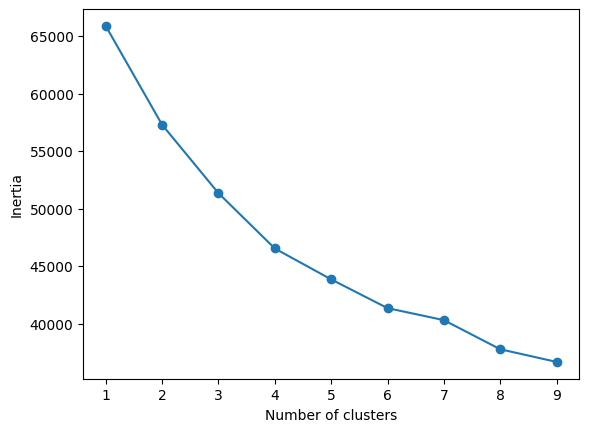

In [22]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
inertias = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)
plt.plot(range(1, 10), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:

print(silhouette_score(X, labels))

0.19307511403237979


In [24]:

for k in range(2, 8):
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X)
    score = silhouette_score(X, labels_temp)
    print(f"Silhouette Score for k={k}: {score:.3f}")

Silhouette Score for k=2: 0.146
Silhouette Score for k=3: 0.179
Silhouette Score for k=4: 0.193
Silhouette Score for k=5: 0.187
Silhouette Score for k=6: 0.202
Silhouette Score for k=7: 0.205


In [27]:
crosstab = pd.crosstab(df_cleaned['cluster'], df_cleaned['persona'], normalize='index')  # Row percentages
print(crosstab)

persona  Unclassified  Youth Side Hustle
cluster                                 
0            1.000000           0.000000
1            0.013278           0.986722
2            0.000000           1.000000
3            0.000000           1.000000


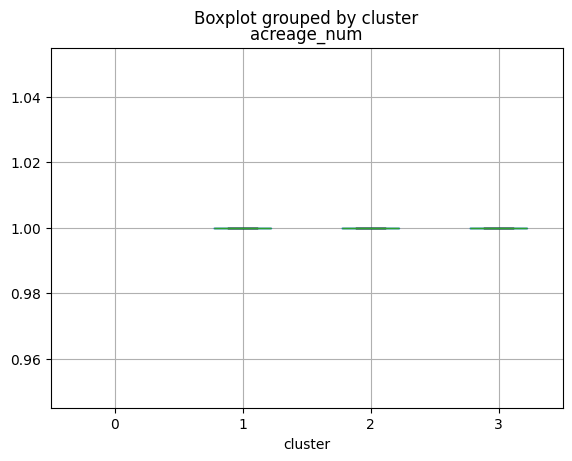

In [28]:
# Example: Boxplot of farm_acreage by cluster (encode acreage numerically first)
df_cleaned['acreage_num'] = df_cleaned['farm_acreage'].map({'2 or less': 1, 'more than 2': 2})
df_cleaned.boxplot(column='acreage_num', by='cluster')
plt.show()

In [32]:
pca = PCA(n_components=0.95)  # Keep 95% variance
X_pca = pca.fit_transform(X)
labels, kmeans_model = run_kmeans(X_pca, n_clusters=5)
df_cleaned['cluster'] = labels

ValueError: n_components=0.95 must be between 1 and min(n_samples, n_features)=39 with svd_solver='arpack'